In [99]:
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection  import GridSearchCV
from sklearn import metrics

In [111]:
df = pd.read_csv('./data/html/all_lyrics.csv')

In [112]:
df.head()

,artist,song_name,songtext
0,System_of_a_Down,Holy_Mountains,can you feel their haunting presence? can you ...
1,Red_Hot_Chili_Peppers,Get_Up_and_Jump,"get up and jump, get up and jump get up, get u..."
2,Red_Hot_Chili_Peppers,Minor_Thing,i change the key from c to d you see to me it...
3,Lady_Gaga,Aura,i killed my former and left her in the trunk o...
4,Lady_Gaga,Million_Reasons,you are giving me a million reasons to let you...


In [114]:
df.groupby('artist').count()

,song_name,songtext
artist,,
Lady_Gaga,123,123
Red_Hot_Chili_Peppers,165,165
System_of_a_Down,60,60


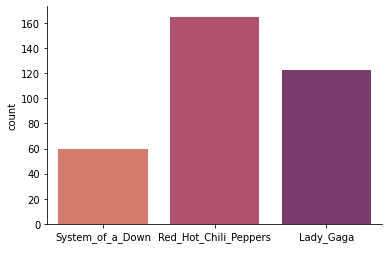

In [115]:
sns.countplot(x='artist', data=df, palette='flare')
plt.xlabel(' ')
sns.despine()

plt.savefig('./output/song_count.jpg')

In [116]:
df['word_count'] = [len(text.split()) for text in df['songtext']]
df.groupby('artist').mean('word_count')

,word_count
artist,
Lady_Gaga,328.284553
Red_Hot_Chili_Peppers,271.333333
System_of_a_Down,226.366667


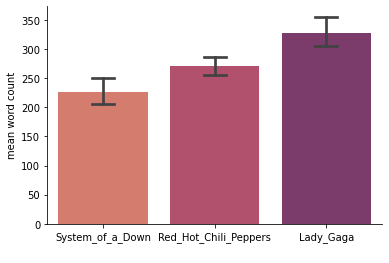

In [117]:
sns.barplot(x='artist', y='word_count', data=df, palette='flare', capsize=.2)
plt.xlabel(' ')
plt.ylabel('mean word count')
sns.despine()

plt.savefig('./output/mean_word_count.jpg')

In [118]:
df.groupby('artist').sum('word_count')

,word_count
artist,
Lady_Gaga,40379
Red_Hot_Chili_Peppers,44770
System_of_a_Down,13582


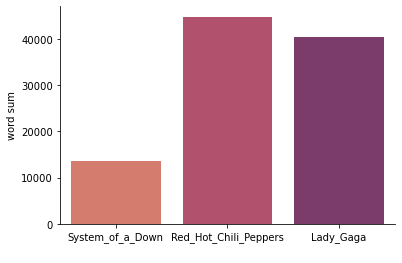

In [119]:
sns.barplot(x='artist', y='word_count', estimator=sum, data=df, palette='flare', ci=None)
plt.xlabel(' ')
plt.ylabel('word sum')
sns.despine()

In [120]:
y = df['artist']
X = df['songtext']

## Train-Test-Split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [122]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((261,), (87,), (261,), (87,))

# CountVectorizer

## Train the Model

In [268]:
model_CV = make_pipeline(
    CountVectorizer(stop_words='english',ngram_range=(1,1), min_df=2, max_df=0.85),
    RandomForestClassifier(max_depth=10, n_estimators=50, class_weight='balanced', ccp_alpha=0.0001)
)
model_CV.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.85, min_df=2, stop_words='english')),
                ('randomforestclassifier',
                 RandomForestClassifier(ccp_alpha=0.0001,
                                        class_weight='balanced', max_depth=10,
                                        n_estimators=50))])

In [269]:
cv_results = cross_validate(
    estimator=model_CV,             # the model you want to evaluate 
    X=X_train,                     # the training input data 
    y=y_train,                     # the training output data  
    cv=5,                    # number of cross validation datasets 
    scoring='accuracy',          # evaluation metric 
    return_train_score=True,   # return both the score on the training and the cross validated data
    n_jobs=1                   # n_jobs = -1 for using all your processores
)

In [270]:
# show results in dataframe
df_cv_results = pd.DataFrame(cv_results)
df_cv_results

,fit_time,score_time,test_score,train_score
0,0.097219,0.011031,0.679245,0.971154
1,0.089508,0.010513,0.634615,0.966507
2,0.089058,0.011530,0.769231,0.952153
3,0.096001,0.012468,0.711538,0.971292
4,0.095119,0.011246,0.711538,0.971292


In [271]:
grid_CV = {
    #'countvectorizer__ngram_range': [(1,1),(1,2)],
    #'countvectorizer__min_df': [ 2,3,4,5,6],
    'countvectorizer__max_df': [ 0.7, 0.8, 0.9],
    #'randomforestclassifier__ccp_alpha': [ 0.00001, 0.0001, 0.001],    
    #'randomforestclassifier__n_estimators': [50,100, 200],
    #'randomforestclassifier__max_depth': [5, 10, 15, 20]
       }

In [272]:
# define the gridsearch 
cv = GridSearchCV(
    model_CV, 
    param_grid=grid_CV, 
    scoring=('accuracy'), 
    return_train_score=True, 
    cv=5,
    n_jobs=-1
)

# fit it
cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_df=0.85, min_df=2,
                                                        stop_words='english')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(ccp_alpha=0.0001,
                                                               class_weight='balanced',
                                                               max_depth=10,
                                                               n_estimators=50))]),
             n_jobs=-1, param_grid={'countvectorizer__max_df': [0.7, 0.8, 0.9]},
             return_train_score=True, scoring='accuracy')

In [273]:
cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_countvectorizer__max_df', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [274]:
cols = [
    #'param_randomforestclassifier__ccp_alpha',
    #'param_countvectorizer__ngram_range',
    'param_countvectorizer__max_df',
    #'param_countvectorizer__min_df',
    #'param_randomforestclassifier__n_estimators', 
    #'param_randomforestclassifier__max_depth',
    'mean_train_score', 
    'mean_test_score',
    'rank_test_score',
]
cv_results = pd.DataFrame(cv.cv_results_)
cv_results[cols].sort_values('rank_test_score').head(10)

,param_countvectorizer__max_df,mean_train_score,mean_test_score,rank_test_score
1,0.8,0.963604,0.685704,1
0,0.7,0.968398,0.678229,2
2,0.9,0.958806,0.628229,3


In [275]:
cv.best_params_

{'countvectorizer__max_df': 0.8}

In [276]:
#best_cv = cv.best_estimator_
best_cv = model_CV
best_cv

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.85, min_df=2, stop_words='english')),
                ('randomforestclassifier',
                 RandomForestClassifier(ccp_alpha=0.0001,
                                        class_weight='balanced', max_depth=10,
                                        n_estimators=50))])

### Test Best Model again with cross validation

In [277]:
cv_results = cross_validate(
    estimator=best_cv,             # the model you want to evaluate 
    X=X_train,                     # the training input data 
    y=y_train,                     # the training output data  
    cv=5,                    # number of cross validation datasets 
    scoring='accuracy',          # evaluation metric 
    return_train_score=True,   # return both the score on the training and the cross validated data
    n_jobs=1                   # n_jobs = -1 for using all your processores
)

In [278]:
# show results in dataframe
df_cv_results = pd.DataFrame(cv_results)
df_cv_results

,fit_time,score_time,test_score,train_score
0,0.114163,0.011512,0.660377,0.961538
1,0.106754,0.012755,0.615385,0.966507
2,0.101846,0.012180,0.711538,0.952153
3,0.084979,0.008813,0.653846,0.942584
4,0.090356,0.010651,0.596154,0.961722


### Fit best model on complete Training Data

In [279]:
best_cv.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.85, min_df=2, stop_words='english')),
                ('randomforestclassifier',
                 RandomForestClassifier(ccp_alpha=0.0001,
                                        class_weight='balanced', max_depth=10,
                                        n_estimators=50))])

In [280]:
# writing
with open('./data/best_model_CV.pickle', 'wb') as file:
    pickle.dump(best_cv, file)

### Test Model on Training Data

In [281]:
y_train_pred = best_cv.predict(X_train)

In [282]:
metrics.accuracy_score(y_train, y_train_pred)

0.9501915708812261

### Baseline Model

In [283]:
y_pred = ['Red_Hot_Chili_Peppers']*len(y_test)

In [284]:
metrics.accuracy_score(y_test, y_pred)

0.5057471264367817

### Test Model on Test Data

In [285]:
y_test_pred = best_cv.predict(X_test)

In [286]:
metrics.accuracy_score(y_test, y_test_pred)

0.6436781609195402

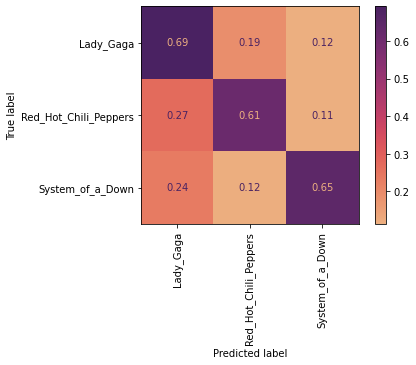

In [287]:
metrics.plot_confusion_matrix(best_cv, X_test, y_test, cmap='flare', normalize='true', xticks_rotation='vertical')
plt.savefig('./output/confusion_matrix.jpg', bbox_inches='tight')

## Result Evaluation

In [309]:
X_train_trans = best_cv[0].fit_transform(X_train)
X_train_trans = pd.DataFrame(X_train_trans.todense(), index=y_train, columns=best_cv[0].get_feature_names())
X_train_trans.index.rename('index', inplace=True)

In [310]:
X_train_trans.head()

,able,aboard,absurd,act,acting,addicted,adjust,adored,affection,afford,...,yell,yellow,yes,yesterday,yo,york,young,youth,zephyr,zone
index,,,,,,,,,,,,,,,,,,,,,
Red_Hot_Chili_Peppers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lady_Gaga,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
System_of_a_Down,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
System_of_a_Down,3,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
System_of_a_Down,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [311]:
top_words = X_train_trans.sum(axis=0).sort_values(ascending=False)[:20]

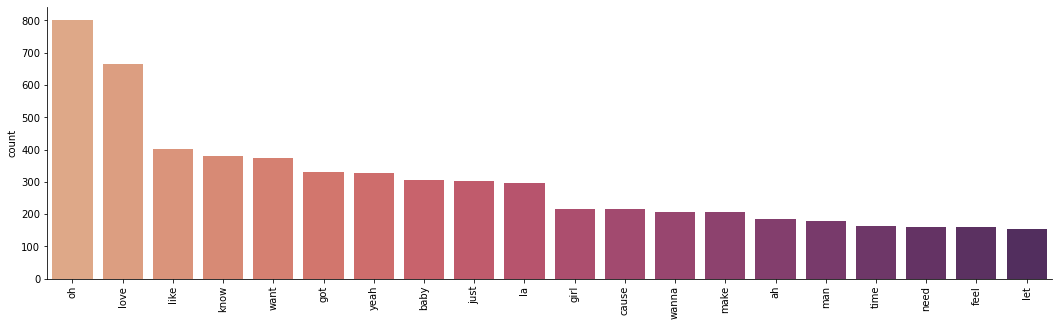

In [331]:
plt.figure(figsize=(18,5))
sns.barplot(x=top_words.index, y=top_words, palette='flare')
sns.despine()
plt.ylabel('count')
plt.xticks(rotation=90)
#plt.show()

plt.savefig('./output/word_count_model.jpg', bbox_inches='tight')

In [313]:
df_words_artists = X_train_trans.groupby('index').sum().transpose()
df_words_artists['total'] = df_words_artists.sum(axis=1)
#df_words_artists

In [314]:
#df_words_artists.sort_values('total', ascending=False)
df_top_20_words = df_words_artists.sort_values('total', ascending=False).iloc[:20,:]
df_top_20_words.head()

index,Lady_Gaga,Red_Hot_Chili_Peppers,System_of_a_Down,total
oh,609,157,36,802
love,442,212,11,665
like,207,163,33,403
know,158,159,63,380
want,211,135,27,373


In [315]:
df_top_20_words_rel = df_top_20_words.copy()
df_top_20_words_rel['Lady_Gaga']= df_top_20_words_rel['Lady_Gaga']/df_top_20_words_rel['total']
df_top_20_words_rel['Red_Hot_Chili_Peppers']= df_top_20_words_rel['Red_Hot_Chili_Peppers']/df_top_20_words_rel['total']
df_top_20_words_rel['System_of_a_Down']= df_top_20_words_rel['System_of_a_Down']/df_top_20_words_rel['total']
df_top_20_words_rel.head()

index,Lady_Gaga,Red_Hot_Chili_Peppers,System_of_a_Down,total
oh,0.759352,0.195761,0.044888,802
love,0.664662,0.318797,0.016541,665
like,0.513648,0.404467,0.081886,403
know,0.415789,0.418421,0.165789,380
want,0.565684,0.361930,0.072386,373


In [316]:
df_top_20_words = df_top_20_words.drop('total', axis=1)
df_top_20_words_rel = df_top_20_words_rel.drop('total', axis=1)

<Figure size 1440x360 with 0 Axes>

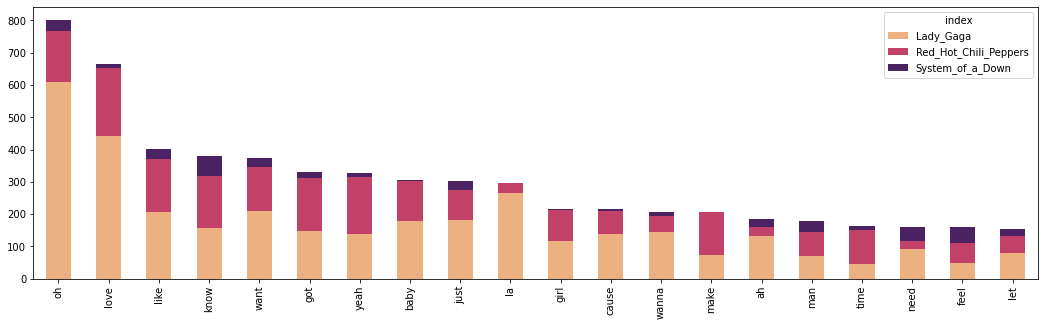

In [317]:
plt.figure(figsize=(20,5))
#sns.set(palette='flare')
df_top_20_words.plot(kind='bar', stacked=True, figsize=(18,5), cmap='flare')
plt.show()

<Figure size 1440x360 with 0 Axes>

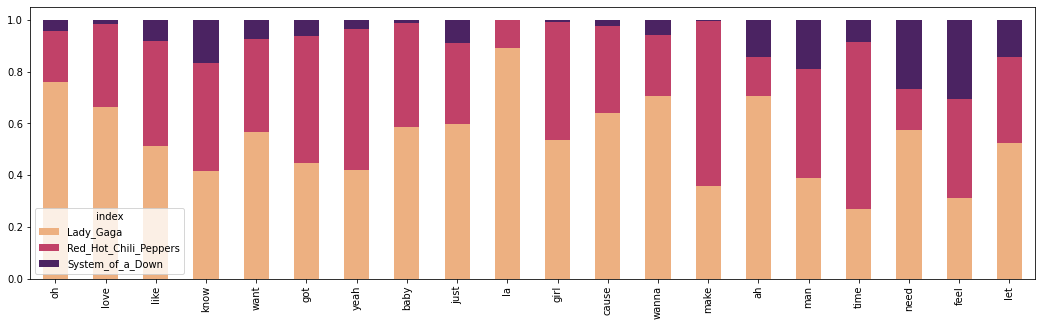

In [336]:
plt.figure(figsize=(20,5))
#sns.set(palette='flare')
df_top_20_words_rel.plot(kind='bar', stacked=True, figsize=(18,5), cmap='flare')

#plt.show()

plt.savefig('./output/word_count_proportions.jpg', bbox_inches='tight')

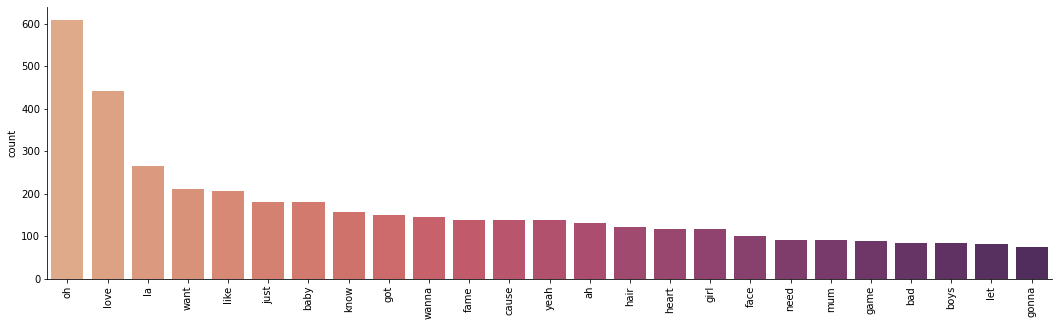

In [337]:
x = df_words_artists['Lady_Gaga'].sort_values(ascending=False)[:25]

plt.figure(figsize=(18,5))
sns.barplot(x=x.index, y=x, palette='flare')
sns.despine()
plt.ylabel('count')
plt.xticks(rotation=90)
#plt.show()

plt.savefig('./output/word_count_lady_gaga.jpg', bbox_inches='tight')

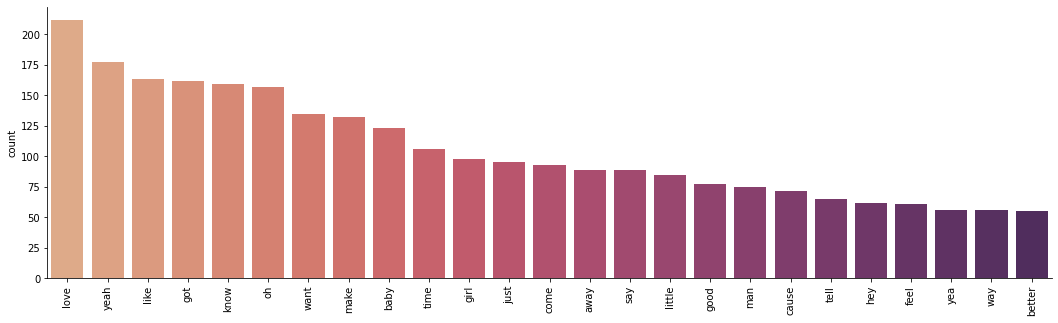

In [338]:
x = df_words_artists['Red_Hot_Chili_Peppers'].sort_values(ascending=False)[:25]

plt.figure(figsize=(18,5))
sns.barplot(x=x.index, y=x, palette='flare')
sns.despine()
plt.ylabel('count')
plt.xticks(rotation=90)
#plt.show()

plt.savefig('./output/word_count_red_hot_chili_peppers.jpg', bbox_inches='tight')

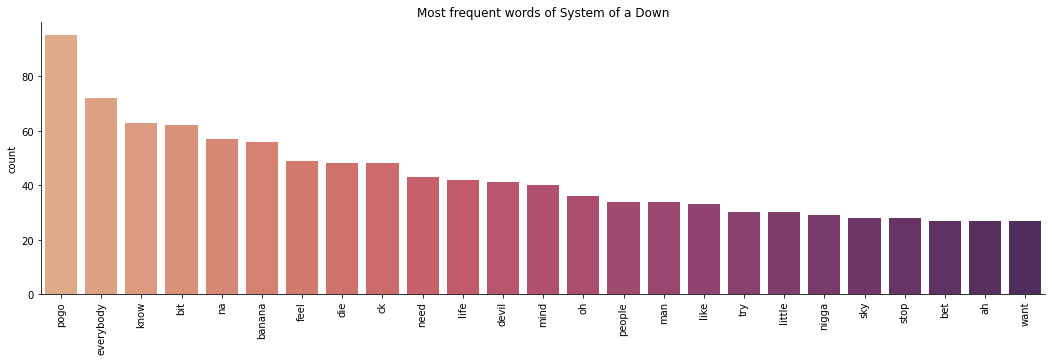

In [342]:
x = df_words_artists['System_of_a_Down'].sort_values(ascending=False)[:25]

plt.figure(figsize=(18,5))
sns.barplot(x=x.index, y=x, palette='flare')
sns.despine()
plt.ylabel('count')
plt.xticks(rotation=90)
plt.title('Most frequent words of System of a Down')
#plt.show()

plt.savefig('./output/word_count_system_of_a_down.jpg', bbox_inches='tight')